# Lecture 3 - Building a logistic regression model on the lung data

## Consider the *lung* data set available form the EPI7913A package
### Load the lung data set form last class

In [1]:
clung <- epi7913A::lung
head(clung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,status.category,sex.category
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,3,306,2,74,1,1,90,100,1175,NA,dead,Male
2,3,455,2,68,1,0,90,90,1225,15,dead,Male
3,3,1010,1,56,1,0,90,90,NA,15,censored,Male
4,5,210,2,57,1,1,90,60,1150,11,dead,Male
5,1,883,2,60,1,0,100,90,NA,0,dead,Male
6,12,1022,1,74,1,1,50,80,513,0,censored,Male


### Remove the two categorical columns we added last time!

In [2]:
# clean up – remove the extra columns we added in the previous class!
# and make a copy of data to clung and remove and rows that contain NA
clung <- clung[,-11:-12]
clung <- clung[complete.cases(clung),]
head(clung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,3,455,2,68,1,0,90,90,1225,15
4,5,210,2,57,1,1,90,60,1150,11
6,12,1022,1,74,1,1,50,80,513,0
7,7,310,2,68,2,2,70,60,384,10
8,11,361,2,71,2,2,60,80,538,1
9,1,218,2,53,1,1,70,80,825,16


## Initialize data splitting ratio, the number of iterations to randomly repeat the experiment 

In [3]:
# initialize parameters for the experiment
train_data_split = 0.6   # 0.6 for training and 1-0.6 for testing
iterations = 1000        # 10 repeated runs -- this is set to 1000 in the notes!

## Initialize the outcome (alive_at_cutoff) as binary indicating if survival >= survival_cutoff 

In [4]:
survival_cutoff = 365/2  # survival cutoff is 6 months = 365/2
# construct the outcome of 1 for those who survive on or above 
# the cutoff value, 0 otherwise
clung <- within(clung, { 
  alive_at_cutoff <- NA; #initialize a new column
  alive_at_cutoff[time >= survival_cutoff] <- 1
  alive_at_cutoff[time < survival_cutoff ] <- 0 
} )

head(clung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,alive_at_cutoff
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
2,3,455,2,68,1,0,90,90,1225,15,1
4,5,210,2,57,1,1,90,60,1150,11,1
6,12,1022,1,74,1,1,50,80,513,0,1
7,7,310,2,68,2,2,70,60,384,10,1
8,11,361,2,71,2,2,60,80,538,1,1
9,1,218,2,53,1,1,70,80,825,16,1


## set the random seed for reproducability and allocate the results table

In [6]:
# set the random seed for reproducibility 
set.seed(17) 

# allocate a matrix to capture the logloss values for each iteration of the experiment
evaluation_results = matrix(,nrow=iterations, ncol=2)
colnames(evaluation_results) <- c("logLoss_train", "logLoss_test")
head(evaluation_results)

logLoss_train,logLoss_test
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA


## The main body of the experiment

## For a number of iterations:
  - ### Partition *clung* into train and test portions as defined by train_data_split and stratified to the ratio of Yes:No in alive_at_cutoff
  - ### Retrieve train and test data
  - ### Construct a generalizable linear model from "alive_at_cutoff ~ age + sex" using a binomial logistic model  
  - ### Calculate the logloss of predicted probabilities to actual values in training data (find goodness of fit)
  - ### Using th resulting model, predict the probabilities on the test data
  - ### Calculate how well the predicted probabilities fit actual values for test data
  - ### Record the goodness of fit on training and logloss on test


In [13]:
# for the number of iterations:
for (i in 1:iterations) {

    # partition clung into train and test portions as defined by train_data_split and stratified to the ratio of Yes:No in alive_at_cutoff
  inds <- splitTools::partition(clung$alive_at_cutoff, p = c(train = train_data_split, test = (1 - train_data_split)), type="stratified")

  #     retrieve train and test data
  train <- clung[inds$train, ]
  test  <- clung[inds$test, ]

  # construct a generalizable linear model from "alive_at_cutoff ~ age + sex" using a binomial logistic model  
  glm_model <- glm(alive_at_cutoff ~   age + sex  , data = train, family=binomial(link = "logit"))
  
  # calculate the log loss of predicted probabilities to actual values in training data (find goodness of fit)
  r1 <- MLmetrics::LogLoss(glm_model$fitted.values, train$alive_at_cutoff)
  
  # using th resulting model, predict the probabilities on the test data
  glm_probs <- predict(glm_model,newdata = test,type = "response")
  
  # calculate how well the predicted probabilities fit actual values for test data
  r2 <- MLmetrics::LogLoss(glm_probs, test$alive_at_cutoff)
  
  # record the goodness of fit on training and logloss on test
  evaluation_results[i,] <- c(r1,r2)
}

head(evaluation_results)

logLoss_train,logLoss_test
0.5814083,0.6114190
0.6052793,0.5804936
0.6007511,0.5990527
0.5954205,0.5858234
0.5924581,0.5924891
0.5860301,0.6241681


In [14]:
glm_model



Call:  glm(formula = alive_at_cutoff ~ age + sex, family = binomial(link = "logit"), 
    data = train)

Coefficients:
(Intercept)          age          sex  
   0.132080    -0.003439     0.677788  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    122.2 
Residual Deviance: 120 	AIC: 126

## Plot the logLoss values collected formt eh various runs

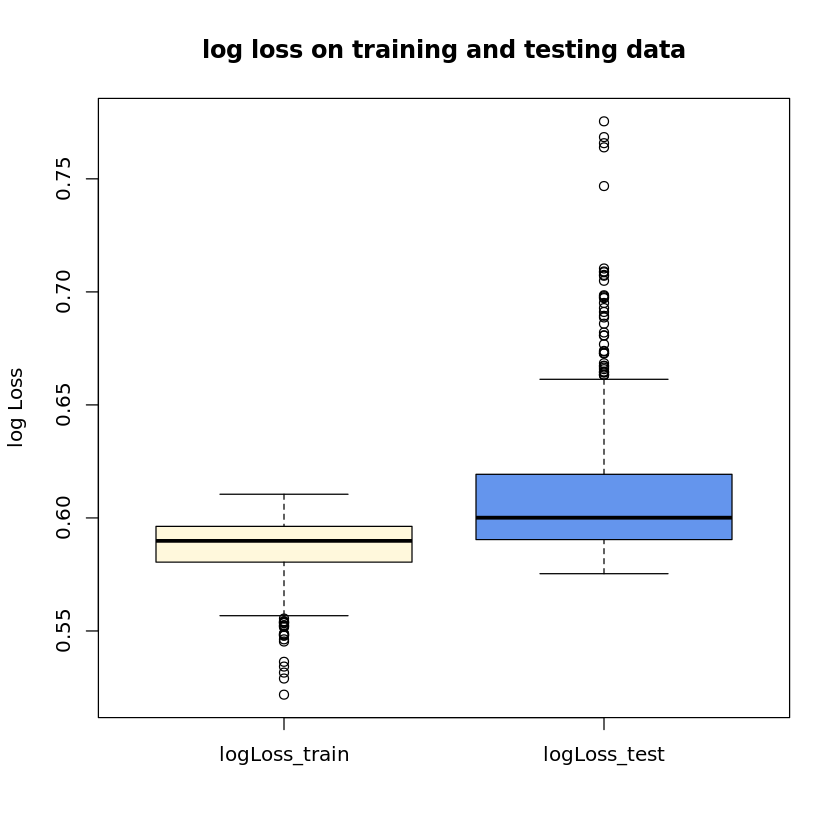

In [15]:
# plot box plots of log los values on training and on testing
boxplot(evaluation_results, col = c("cornsilk","cornflowerblue"), 
        ylab = "log Loss", main = "log loss on training and testing data")